In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import pandas as pd
import numpy as np
import matplotlib
from IPython.display import *

import AssembleData

In [3]:

# Build Dataframe 
#MAL_df, all_genre  = AssembleData.read_files_all(verbose=True)
#MAL_df = MAL_df.drop_duplicates('id')

In [78]:
import pickle

#MAL_df = MAL_df.drop_duplicates('id')
#with open('augmented_1998_2015_data.pkl', 'w') as f:
#    pickle.dump(MAL_df, f)
#    pickle.dump(all_genre, f)

with open('augmented_1998_2015_data.pkl', 'r') as f:
    MAL_df = pickle.load(f)
    all_genre = pickle.load(f)

In [5]:
def only_genre(g):
    return MAL_df[MAL_df[g] == 1]

In [38]:
def get_std(entry):
    #print entry
    scores = []
    scores.append([10] * entry["score_10_votes"])
    scores.append([9] * entry["score_9_votes"])
    scores.append([8] * entry["score_8_votes"])
    scores.append([7] * entry["score_7_votes"])
    scores.append([6] * entry["score_6_votes"])
    scores.append([5] * entry["score_5_votes"])
    scores.append([4] * entry["score_4_votes"])
    scores.append([3] * entry["score_3_votes"])
    scores.append([2] * entry["score_2_votes"])
    scores.append([1] * entry["score_1_votes"])

    scores = [val for sublist in scores for val in sublist]

    #print scores
    return np.std(scores)

def get_df_std(df):
    scores = []
    for idx, entry in df.iterrows():
        scores.append([10] * entry["score_10_votes"])
        scores.append([9] * entry["score_9_votes"])
        scores.append([8] * entry["score_8_votes"])
        scores.append([7] * entry["score_7_votes"])
        scores.append([6] * entry["score_6_votes"])
        scores.append([5] * entry["score_5_votes"])
        scores.append([4] * entry["score_4_votes"])
        scores.append([3] * entry["score_3_votes"])
        scores.append([2] * entry["score_2_votes"])
        scores.append([1] * entry["score_1_votes"])

    scores = [val for sublist in scores for val in sublist]

    #print scores
    return np.std(scores)


In [79]:
MAL_df["std"]  = MAL_df.apply(lambda x: get_std(x), axis = 1)
MAL_df['length'] = MAL_df['duration'] * MAL_df['episodes']
MAL_df['studios'] = MAL_df['studios'].apply(lambda s: eval(s))
MAL_df['aired_start'] = pd.to_datetime(MAL_df['aired_start'])

#print MAL_df.head()

In [80]:
sig_length = MAL_df[MAL_df['length'] > 30]

stat_df = sig_length[sig_length['score_users'] > 20000]

In [73]:
#print stat_df.sort_values('std', ascending=False)[['title', 'score_users', 'std']]

#std of all shows
#print stat_df.sort_values('std', ascending=False)[['title', 'score_users', 'std']]


#std by genre
genre_data = []
for g in all_genre:
    genre_df = stat_df[stat_df[g] == 1]
    genre_data.append([g, get_df_std(genre_df)])
    
genre_df = pd.DataFrame(genre_data,columns=['genre', 'std'])
print genre_df.sort_values('std', ascending=False)

                             genre       std
42                            yaoi  3.399728
29                          hentai  3.399728
39                            yuri  2.083625
36                      shounen ai  1.813439
25                           ecchi  1.717388
20                          horror  1.708773
24                           harem  1.705014
30                         vampire  1.704857
41                       shoujo ai  1.702804
37                            game  1.699607
6                     martial arts  1.680030
35                        dementia  1.677329
15                         romance  1.658367
28                          parody  1.644818
16                          shoujo  1.641832
10                         fantasy  1.641182
7                           school  1.636971
4                           sci-fi  1.634894
12                     super power  1.634689
27                   psychological  1.632912
0                           action  1.624122
17        

# PLOT

action
adventure
comedy
drama
sci-fi
space
martial arts
school
shounen
demons
fantasy
magic
super power
historical
supernatural
romance
shoujo
mecha
military
kids
horror
sports
slice of life
samurai
harem
ecchi
mystery
psychological
parody
hentai
vampire
cars
seinen
police
music
dementia
shounen ai
game
thriller
yuri
josei
shoujo ai
yaoi
no genres have been added yet.


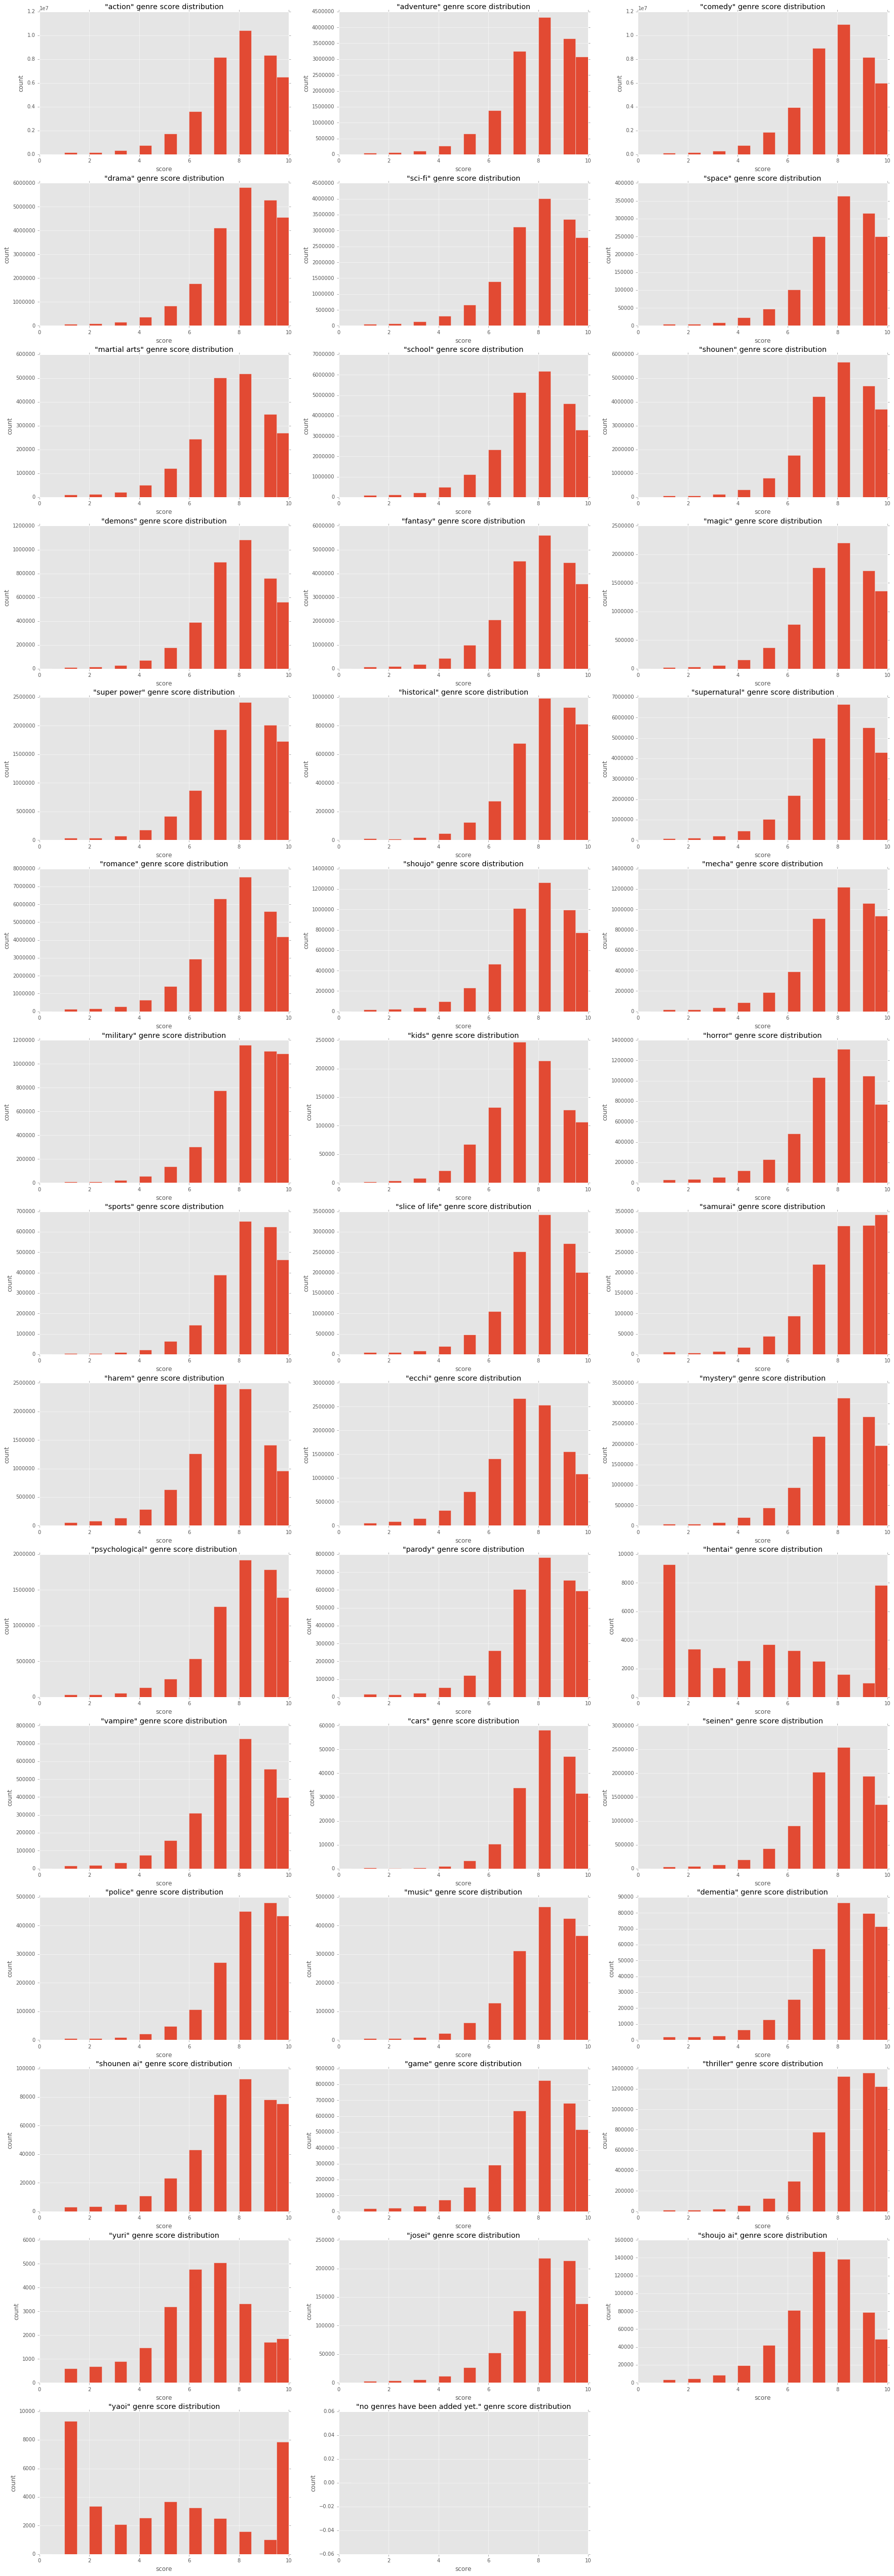

In [88]:
matplotlib.rcParams['figure.figsize'] = (30.0, 90.0)
plt.figure(1)
plt.gca().set_xscale("linear")

cols = 3
rows = np.ceil(len(all_genre) / float(cols))
i = 1
for g in all_genre:
    print g
    plt.subplot(rows, cols, i)
    genre_df = stat_df[stat_df[g] == 1]
    scores = []
    for idx, entry in genre_df.iterrows():
        scores.append([10] * entry["score_10_votes"])
        scores.append([9] * entry["score_9_votes"])
        scores.append([8] * entry["score_8_votes"])
        scores.append([7] * entry["score_7_votes"])
        scores.append([6] * entry["score_6_votes"])
        scores.append([5] * entry["score_5_votes"])
        scores.append([4] * entry["score_4_votes"])
        scores.append([3] * entry["score_3_votes"])
        scores.append([2] * entry["score_2_votes"])
        scores.append([1] * entry["score_1_votes"])

    scores = [val for sublist in scores for val in sublist]
    plt.hist(scores, bins=20, range=[0.0,10.0])
    plt.xlabel("score")
    plt.ylabel("count")
    plt.title('"%s" genre score distribution' % g)
    i += 1
    
    

In [75]:
all_studios = build_studios_set(MAL_df)

In [76]:
def make_studio_features(df, studio_names):
    new_df = df[['id', 'studios']].copy()
    for studio in studio_names:
        new_df[studio] = new_df['studios'].apply(lambda l: studio in l).astype(float)
    combined = pd.merge(df, new_df, how='left', left_on='id', right_on='id')
    return combined

def split_field(df, field, new_field_name=None):
    new_rows = []
    for index, row in df.iterrows():
        for item in row[field]:
            new_rows.append((row['id'], item))
            
    needs_replace = False
    if new_field_name is None or len(new_field_name) == 0:
        new_field_name = "__temp_" + field
        needs_replace = True
        
    right_df = pd.DataFrame(new_rows, columns=['id', new_field_name])
    new_df = pd.merge(df, right_df, how='left', left_on='id', right_on='id')
    if needs_replace:
        del new_df[field]
        new_df[field] = new_df[new_field_name]
        del new_df[new_field_name]
        
    return new_df

def build_studios_set(df):
    split = split_field(df[['id', 'studios']], 'studios')
    split.dropna(axis=0, subset=['studios'], inplace=True)
    return list(set(split['studios']))

stat_df = make_studio_features(stat_df, all_studios)

studio_data = []
for s in all_studios:
    studio_df = stat_df[stat_df[s] == 1]
    studio_data.append([s, get_df_std(studio_df)])
    #print s
    
studio_df = pd.DataFrame(studio_data,columns=['studio', 'std'])

KeyError: "['studios'] not in index"

In [ ]:
studio_df = studio_df.dropna(axis=0, subset=['std'])
print studio_df.sort_values('std', ascending=False)

# Shitty Regression Analysis

When using simple linear regression to predict scores and member count from the genre tags, we confirmed some of our initial suspicions and learned a bit more about the demographic of members on MyAnimeList.

The first thing that stuck out were the genres that were negatively correlated with score and member counts. Unsurprisingly, ecchi, yuri, and yaoi shows had a negative correlation, which is to be expected as shows in these genres are more sexually charged, something which is somewhat offputting to the average user. Interestinly, the kids genre was the most negatively correlated with regards to score and popularity. While this initially seems surprising, it is explained by the fact that MyAnimeList users are at the age where they've outgrown those kinds of shows. Coupled with the fact that kids shows tend to be less complex, its negative correlation is unsurprising.

As for positively correlated genres, it wasn't very surprising to find thriller, psycological, romance and action genres in those positions. Something that was surprising was to see that the harem genre was very positively correlated with popularity. 